# Evaluate models using a variety of metrics

## notes

1. accuracy for 0s and 1s respectively, on players at end of career; theoretically, this should be pretty good, but bad for KNN / Rocket so drop those
* knn takes very long to eval (0.18421052631578946, 0.9320388349514563)
2. choose good models to do more advanced comparisons on
3. plots and shit; remember % false positives that got votes (50%)
4. (TODO) probabilities of players making the hall


## powerpoint flow:
1. problem overview
2. data preprocessing + formatting methods (agg and ts)
3. hypotheses
4. models used + basic parameter descriptions + predictions
5. basic accuracy -> zeros / ones -> full career accuracies
6. more advanced accuracy metrics: f1, ROC AUC, mean metric *** time series drops off less for less data
7. conclusion: of players who played for all of 2015 - 2020, give some probabilities based on the ensemble model
8. who did what: Artun did agg, Nick did ts

In [1]:
import numpy as np
import pandas as pd
from scipy.special import softmax
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, roc_curve, roc_auc_score, plot_roc_curve, precision_recall_curve, jaccard_score, brier_score_loss, classification_report

## Load model predictions

In [2]:
y_test = np.load('../data_ready/y_test.npy')
test_player_ids = np.load('../data_ready/test_player_ids.npy', allow_pickle=True)
test_last_years_idxs = np.load('../data_ready/test_last_years_idxs.npy')

preds_nn = np.load('model_outputs/preds_nn.npy')
preds_lstm = np.load('model_outputs/preds_lstm.npy')
preds_rf = np.load('model_outputs/preds_rf.npy')
preds_rocket = np.load('model_outputs/preds_rocket.npy')
preds_svm = np.load('model_outputs/preds_svm.npy')
preds_rf_ts = np.load('model_outputs/preds_rf_ts.npy')

preds_all = [preds_nn, preds_lstm, preds_rf, preds_rocket, preds_svm, preds_rf_ts]

probs_nn = np.load('model_outputs/probs_nn.npy')[:, 1]
probs_lstm = np.load('model_outputs/probs_lstm.npy')[:, 1]
probs_rf = np.load('model_outputs/probs_rf.npy')
probs_rocket = np.load('model_outputs/probs_rocket.npy')[:, 1]
probs_svm = np.load('model_outputs/probs_svm.npy')
probs_rf_ts = np.load('model_outputs/probs_rf_ts.npy')


probs_all = [probs_nn, probs_lstm, probs_rf, probs_rocket, probs_svm, probs_rf_ts]
probs_ensemble = np.mean(probs_all[0:2], axis=0)
probs_all.append(probs_ensemble)

preds_all.append(probs_ensemble >= 0.5)

model_names = ['nn (agg)', 'lstm (ts)', 'rf (agg)', 'rocket (ts)', 'svm (agg)', 'rf (ts)', 'ensemble (nn + lstm)']


test_player_ids = np.load('../data_ready/test_player_ids.npy', allow_pickle=True)
test_years_played = np.load('../data_ready/test_years_played.npy')
agg_df = pd.read_csv('../data_ready/agg/batting_norm_agg.csv')

In [3]:
batting_df = pd.read_csv('../data_normalized/batting_norm_batters_only.csv')

### Random explorations

In [9]:
batting_br = batting_df[batting_df['player_id'] == 'ruthba01']
batting_br[['player_id', 'year'] + list(batting_br.columns[:7]) + list(batting_br.columns[8:-1])]

,player_id,year,Unnamed: 0,ab,bb,double,g,h,hbp,player_id,r,rbi,sb,sh,so,triple
290,ruthba01,1914,290,-0.821803,-0.725235,-0.596890,-0.990914,-0.753313,-0.586126,ruthba01,-0.703345,-0.630494,-0.583482,-0.759920,-0.803441,-0.633776
505,ruthba01,1915,505,-0.387952,-0.290156,0.445762,-0.251617,-0.237822,-0.565728,ruthba01,-0.128824,0.207138,-0.575753,-0.505489,0.206440,-0.358023
699,ruthba01,1916,699,-0.104638,-0.175364,-0.080899,0.287476,-0.029144,-0.548261,ruthba01,0.046753,0.035815,-0.567466,-0.179824,0.270399,0.232131
884,ruthba01,1917,884,-0.233537,-0.110487,0.007586,-0.064928,-0.030505,-0.554721,ruthba01,-0.171862,-0.161685,-0.577313,0.083542,0.016855,0.182731
1052,ruthba01,1918,1052,1.129302,2.863403,3.186052,1.240359,1.354196,0.609910,ruthba01,1.703299,3.023614,0.267293,-0.295258,3.841417,3.178635
1230,ruthba01,1919,1230,1.543553,5.044375,3.244974,1.733362,1.889538,2.538812,ruthba01,3.469763,4.611793,0.369140,-0.335581,3.218965,2.882419
1434,ruthba01,1920,1434,1.424177,6.941732,2.723950,1.726378,2.040729,0.876766,ruthba01,4.513261,4.400074,1.527932,-0.133413,4.197018,1.581165
1662,ruthba01,1921,1662,1.796784,6.455148,3.217795,1.909160,2.388160,1.404748,ruthba01,4.577671,4.951231,2.326007,-0.250812,4.356698,3.075533
1909,ruthba01,1922,1909,1.157114,3.404631,1.475022,1.077687,1.235113,-0.096968,ruthba01,2.123666,2.607721,-0.154615,-0.247030,4.481925,1.429960
2174,ruthba01,1923,2174,1.797222,7.026003,3.447716,1.948379,2.567925,1.285386,ruthba01,3.987618,3.785065,2.231241,-0.324481,5.246703,2.921778


In [10]:
agg_df_br = agg_df[agg_df['player_id'] == 'ruthba01'].drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
agg_df_br[['player_id'] + list(agg_df_br.columns[:7]) + list(agg_df_br.columns[8:])][2:3]

,player_id,ab,bb,double,g,h,hbp,hr,r,rbi,sb,sh,so,triple,years_played,hof
871,ruthba01,-1.314393,-1.190755,-0.232028,-0.955056,-1.02028,-1.700115,2.362548,-0.785416,-0.38754,-1.726701,-1.445233,-0.326602,-0.759669,3.0,True


In [11]:
agg_df['hof'].mean()

0.05280263669863359

In [12]:
agg_df

,Unnamed: 0,Unnamed: 0.1,ab,bb,double,g,h,hbp,hr,player_id,r,rbi,sb,sh,so,triple,years_played,hof
0,0,0,-0.661588,-0.438871,-0.640879,-0.705525,-0.583966,-0.539028,-0.388342,acostme01,-0.539369,-0.609924,-0.335788,-0.665060,-0.794309,-0.310270,1.0,False
1,1,1,-1.145500,-0.634319,-1.124076,-1.026475,-1.017650,-1.125153,-0.813317,acostme01,-0.903027,-1.153566,-0.636014,-1.424980,-0.892177,-0.404662,2.0,False
2,2,2,-1.161406,-0.031041,-1.378979,-0.693510,-1.160762,-0.056680,-1.235447,acostme01,-0.879855,-1.079926,-0.389503,-1.058649,-1.112142,-0.762685,3.0,False
3,3,3,-1.954610,-0.615781,-2.052017,-1.647343,-1.893377,-0.604941,-1.638442,acostme01,-1.575987,-1.775687,-0.956969,-1.764229,-2.108656,-1.364642,4.0,False
4,4,4,-1.744661,-0.229190,-2.314481,-1.438181,-1.531243,-1.148788,-2.011442,acostme01,-1.190280,-1.700775,-0.966303,-1.027140,-2.202136,-0.952990,5.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43686,43686,44209,-0.448198,-0.350041,-0.506754,-0.542378,-0.443520,-0.452528,-0.364299,turnetr01,-0.407728,-0.547344,0.027295,-0.478008,-0.390894,-0.427949,1.0,False
43687,43687,44210,0.781068,0.410928,0.186854,0.614127,0.573732,0.309030,0.325219,urshegi01,0.382690,0.258928,-0.357982,0.058954,0.748672,0.186402,1.0,False
43688,43688,44211,-0.659393,-0.567460,-0.605841,-1.099213,-0.623035,-0.452528,-0.502202,waldrky02,-0.605333,-0.587657,-0.357982,-0.478008,-0.663400,-0.427949,1.0,False
43689,43689,44212,-0.551088,-0.513105,-0.308580,-0.949296,-0.503358,-0.452528,-0.364299,willima07,-0.486770,-0.466716,-0.357982,-0.478008,-0.613853,-0.427949,1.0,False


In [4]:
def test_last_n_years_idxs(n):
    """
    Return samples from test dataset that include any of the last n years of a player's career
    """
    player_career_lengths = agg_df.groupby('player_id')['years_played'].max().to_dict()
    return [i for i in range(len(y_test)) if player_career_lengths[test_player_ids[i]] - n < test_years_played[i]]

In [5]:
def test_years_before_end(n):
    """
    Return samples from test dataset that include only samples that end on exactly the nth year before the end of a player's career
    """
    player_career_lengths = agg_df.groupby('player_id')['years_played'].max().to_dict()
    return [i for i in range(len(y_test)) if player_career_lengths[test_player_ids[i]] - n == test_years_played[i]]

In [6]:
y_test_full, preds_ens_full = y_test[test_last_n_years_idxs(1)], preds_all[-1][test_last_n_years_idxs(1)]

### TP rate, FN rate, FP rate

In [22]:
tp = np.sum((y_test_full == 1) & (preds_ens_full == 1))
tn = np.sum((y_test_full == 0) & (preds_ens_full == 0))
fp = np.sum((y_test_full == 0) & (preds_ens_full == 1))
fn = np.sum((y_test_full == 1) & (preds_ens_full == 0))

In [23]:
tp / (tp + fn), fn / (fn + tp), fp / (fp + tn)

(0.9210526315789473, 0.07894736842105263, 0.041707080504364696)

## Basic accuracy analysis

In [24]:
def basic_accs(preds_all):
    """
    Compute basic accuracy metrics for all models
    """
    player_career_lengths = agg_df.groupby('player_id')['years_played'].max().to_dict()
    full_idxs_ones = [i for i in range(len(y_test)) if player_career_lengths[test_player_ids[i]] == test_years_played[i] and y_test[i] == 1]
    full_idxs_zeros = [i for i in range(len(y_test)) if player_career_lengths[test_player_ids[i]] == test_years_played[i] and y_test[i] == 0]
    
    # overall
    overalls = [np.mean(preds == y_test) for preds in preds_all]
    # zeros
    zeros = [np.mean(preds[y_test == 0] == y_test[y_test == 0]) for preds in preds_all]
    # ones
    ones = [np.mean(preds[y_test == 1] == y_test[y_test == 1]) for preds in preds_all]
    # full career zeros 
    full_zeros = [np.mean(preds[full_idxs_zeros] == y_test[full_idxs_zeros]) for preds in preds_all]
    # full career ones
    full_ones = [np.mean(preds[full_idxs_ones] == y_test[full_idxs_ones]) for preds in preds_all]
    
    return overalls, zeros, ones, full_zeros, full_ones

In [25]:
for i in range(len(preds_all)):
    display(model_names[i], [np.round(x[i], 2) for x in basic_accs(preds_all)])

'nn (agg)'

[0.94, 0.97, 0.54, 0.98, 0.79]

'lstm (ts)'

[0.83, 0.83, 0.77, 0.93, 0.92]

'rf (agg)'

[0.96, 0.99, 0.31, 0.99, 0.68]

'rocket (ts)'

[0.93, 0.97, 0.14, 0.97, 0.26]

'svm (agg)'

[0.94, 0.99, 0.21, 1.0, 0.11]

'rf (ts)'

[0.95, 1.0, 0.12, 1.0, 0.18]

'ensemble (nn + lstm)'

[0.89, 0.9, 0.71, 0.96, 0.92]

In [9]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']

In [10]:
sample_weight = np.zeros(y_test.shape)
sample_weight[y_test == 0] = 0.05
sample_weight[y_test == 1] = 1

## Advanced metrics

In [29]:
def plot_prcs(y_test, probs_all, colors=colors):
    """
    Plots precision-recall curves for all models
    """
    plt.figure()
    lw = 2
    
    for i, probs in enumerate(probs_all):
        p, r, _ = precision_recall_curve(y_test, probs, sample_weight=sample_weight)
        plt.plot(p, r, color=colors[i],
                 lw=lw, label=model_names[i] + ' (area = %0.2f)' % roc_auc_score(y_test, probs, sample_weight=sample_weight))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision / recall curve')
    plt.legend(loc="lower left")
    plt.show()

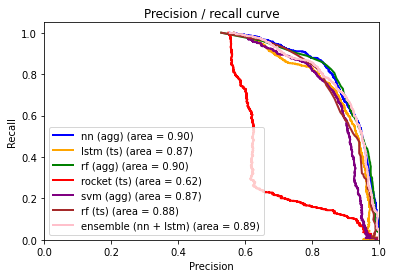

In [30]:
plot_prcs(y_test, probs_all)

In [11]:
def plot_rocs(y_test, probs_all, sample_weight, colors=colors, title='ROC curve over all samples'):
    """
    Plots ROC curves for all models
    """
    plt.figure()
    lw = 2
    
    for i, probs in enumerate(probs_all):
        fpr, tpr, _ = roc_curve(y_test, probs, sample_weight=sample_weight)
        plt.plot(fpr, tpr, color=colors[i],
                 lw=lw, label=model_names[i] + ' (area = %0.2f)' % roc_auc_score(y_test, probs, sample_weight=sample_weight))
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

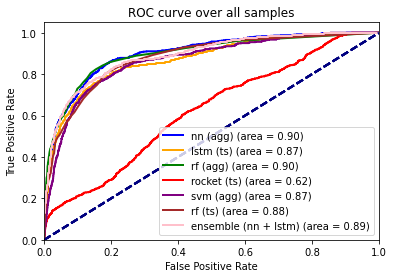

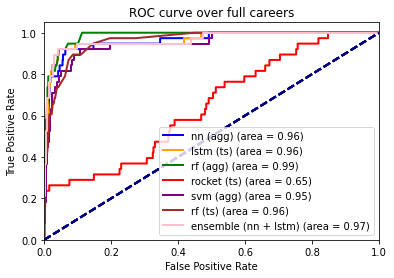

In [12]:
plot_rocs(y_test, probs_all, sample_weight)
plot_rocs(y_test[test_last_n_years_idxs(1)], [x[test_last_n_years_idxs(1)] for x in probs_all], sample_weight[test_last_n_years_idxs(1)], title='ROC curve over full careers')

In [13]:
def plot_metric(metric, metric_name='', ylabel='Model score', fmt='standard'):
    """
    Plots a given metric for all models, with samples partitioned according to test_years_before_end(i)
    
    if fmt='cumulative', accumulates samples from right to left (rightmost end of plot is just full careers, leftmost end is all samples)
    if fmt='standard', does not accumulate samples
    """
    scores = []
    if fmt == 'cumulative':
        for n in range(1, 26):
            idxs = test_last_n_years_idxs(n)
            scores.append([metric(y_test[idxs], preds[idxs], sample_weight=sample_weight[idxs]) for preds in preds_all])
    else:
         for n in range(0, 21):
            idxs = test_years_before_end(n)
            scores.append([metric(y_test[idxs], preds[idxs], sample_weight=sample_weight[idxs]) for preds in preds_all])

    plt.plot(scores)
    plt.legend(model_names, loc=(1.05, 0))
    
    plt.xlabel('Years before end of career')
    plt.ylabel(ylabel)
    if fmt == 'cumulative':
        plt.title('Cumulative ' + metric_name + ' Score Throughout Careers')
        plt.xlim(25, 0)
    else:
        plt.title(metric_name + ' Score Throughout Careers')
        plt.xlim(20, 0)
    return scores

In [14]:
mean_metric = lambda a,b,sample_weight: np.mean([metric(a,b,sample_weight=sample_weight) for metric in (one_minus_brier, roc_auc_score, f1_score, jaccard_score)], axis=0)

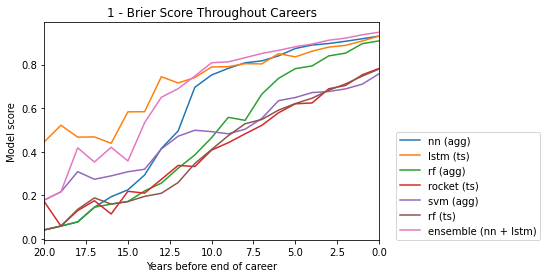

In [16]:
one_minus_brier = lambda a,b,sample_weight: 1-brier_score_loss(a,b,sample_weight=sample_weight)
plot_metric(one_minus_brier, '1 - Brier');

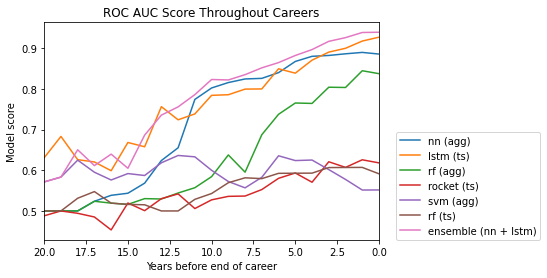

In [69]:
plot_metric(roc_auc_score, 'ROC AUC');

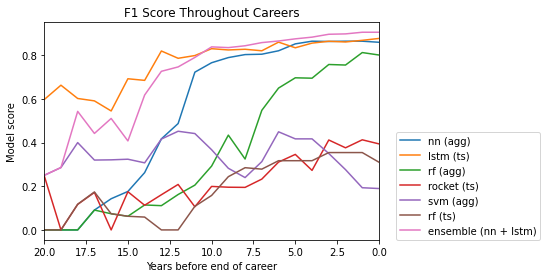

In [70]:
plot_metric(f1_score, 'F1');

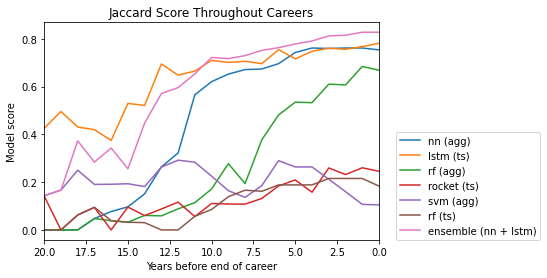

In [71]:
plot_metric(jaccard_score, 'Jaccard');

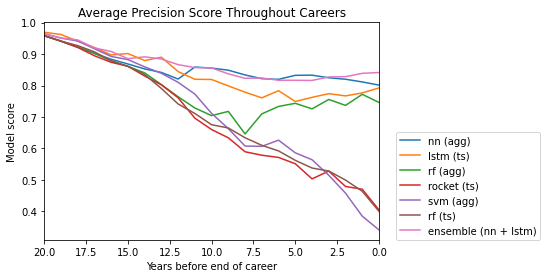

In [72]:
plot_metric(average_precision_score, 'Average Precision');

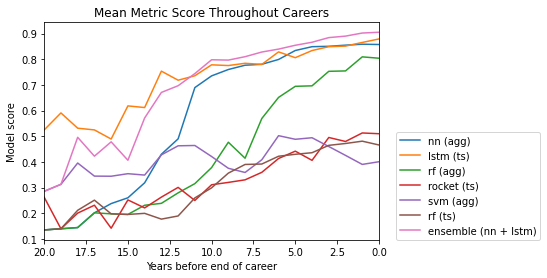

In [73]:
plot_metric(mean_metric, 'Mean Metric');

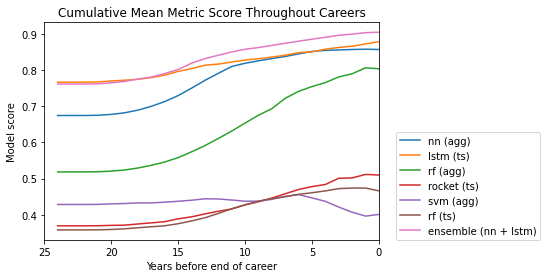

In [17]:
plot_metric(mean_metric, 'Mean Metric', fmt='cumulative');

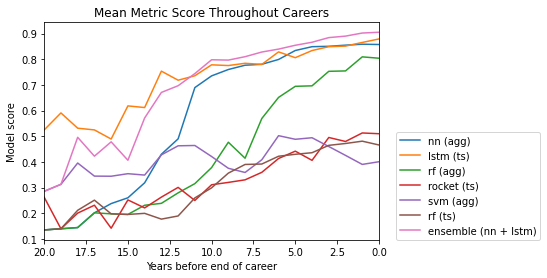

In [18]:
# LSTM vs Ensemble on mean metric
mean_scores = plot_metric(mean_metric, 'Mean Metric')
lstm_scores = [x[1] for x in mean_scores]
ens_scores = [x[-1] for x in mean_scores]

Text(0, 0.5, 'Score difference')

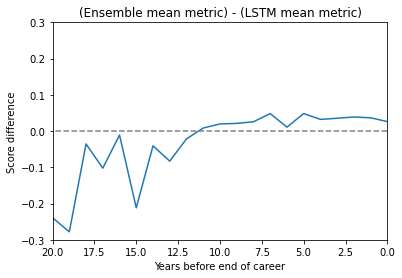

In [113]:
plt.plot(np.array(ens_scores) - np.array(lstm_scores))
plt.xlim(20, 0)
plt.ylim(-0.3, 0.3)
plt.plot([0] * 21, c='gray', ls='dashed')
plt.title('(Ensemble mean metric) - (LSTM mean metric)')
plt.xlabel('Years before end of career')
plt.ylabel('Score difference')

Based on the above plot, ensemble model does better within 10 years of the end of a player's career (but the difference is small)  

LSTM does better more than 10 years before the end of a player's career, so it should be used for young players who are expected to have long careers 

If we had to choose one, just use LSTM; ensemble advantage is relatively small, due to the neural network's poor performance on early-career samples 

## Determine what percent of false-positive guesses got Hall of Fame votes for each model

In [79]:
def percent_fp_got_votes(y_true, y_probs, idx_player_ids): # about half
    fp_idxs = np.where((y_true == 0) & (y_probs >= 0.5))[0]
#     print(len(fp_idxs) / len(y_true))
    fp_players = np.unique(idx_player_ids[fp_idxs])
#     print(y_probs[fp_idxs])
#     print(fp_players, idx_player_ids[fp_idxs][np.argmax(y_probs[fp_idxs])])
    hof = pd.read_csv('../data_normalized/hall_of_fame.csv')
    return np.mean(np.isin(fp_players, hof['player_id']))

In [97]:
[percent_fp_got_votes(y_test[test_years_before_end(0)], preds[test_years_before_end(0)], test_player_ids[test_years_before_end(0)]) for preds in preds_all]

[0.7777777777777778,
 0.4852941176470588,
 0.7777777777777778,
 0.14545454545454545,
 0.5,
 0.6666666666666666,
 0.5930232558139535]

## Analysis of model accuracies vs. years before end of career

In [75]:
def eval_preds(preds, y_test):
    """
    Evaluate model performance on 1s and 0s for the given predictions / labels
    """
    ones_preds, zeros_preds, ones_score, zeros_score = None, None, None, None
    n_ones = np.sum(y_test)
    n_zeros = np.sum(1-y_test)
    try:
        ones_preds = preds[y_test == 1]
        ones_score = np.sum(ones_preds) / len(ones_preds)
    except:
        pass
    try:
        zeros_preds = preds[y_test == 0]
        zeros_score = np.sum(1-zeros_preds) / len(zeros_preds)
    except:
        pass
    
    return ones_preds, zeros_preds, (ones_score, n_ones), (zeros_score, n_zeros), f1_score(y_test, preds, pos_label=0), f1_score(y_test, preds, pos_label=1)

In [76]:
def eval_by_year(preds, y_test, agg_df, test_player_ids, test_years_played, test_zeros_ratio=1, years_before_end=-1):
    """
    Return eval_preds for a given value of years_before_end
    """
    if years_before_end != -1:
        player_career_lengths = agg_df.groupby('player_id')['years_played'].max().to_dict()
        test_idxs_this_year = [i for i in range(len(y_test)) if player_career_lengths[test_player_ids[i]] - years_before_end == test_years_played[i]]

        preds_this_year, y_test_this_year = preds[test_idxs_this_year], y_test[test_idxs_this_year]
        
        test_0s = np.where(y_test_this_year==0)[0]
        np.random.seed(1)
        idxs_sample_0s = np.random.choice(test_0s, size=int(len(test_0s) * test_zeros_ratio), replace=False)
        
        idxs = np.concatenate((idxs_sample_0s, np.where(y_test_this_year==1)[0]))
#         print(preds_this_year[idxs].shape, y_test_this_year[idxs].shape, eval_nn(preds_this_year[idxs], y_test_this_year[idxs]))
        if years_before_end == 0:
            print(classification_report(y_test_this_year[idxs], preds_this_year[idxs]))
            print(percent_fp_got_votes(y_test_this_year[idxs], preds_this_year[idxs], test_player_ids[test_idxs_this_year][idxs]))
        return eval_preds(preds_this_year[idxs],  y_test_this_year[idxs])
    else:
        return eval_preds(preds, y_test)

In [77]:
def eval_all_years(preds):
    """
    Runs eval_by_year for all valid values of years_before_end
    """
    years = []
    for i in range(26):
        res = eval_by_year(preds, y_test, agg_df, test_player_ids, test_years_played, years_before_end=i)
        years.append(res[2:])
    return years

In [ ]:
ens_res = eval_all_years(preds_all[-1])
ens_1s_acc = [x[0][0] for x in ens_res]

ens_0s_acc = [x[1][0] for x in ens_res]

In [ ]:
nn_res = eval_all_years(preds_nn)
lstm_res = eval_all_years(preds_lstm)
rf_res = eval_all_years(preds_rf)
rf_ts_res = eval_all_years(preds_rf_ts)

In [119]:
nn_f1_1s = [x[3] for x in nn_res]
lstm_f1_1s = [x[3] for x in lstm_res]
rf_f1_1s = [x[3] for x in rf_res]
rf_ts_f1_1s = [x[3] for x in rf_ts_res]


nn_1s_acc = [x[0][0] for x in nn_res]
lstm_1s_acc = [x[0][0] for x in lstm_res]
rf_1s_acc = [x[0][0] for x in rf_res]
rf_ts_1s_acc = [x[0][0] for x in rf_ts_res]



nn_0s_acc = [x[1][0] for x in nn_res]
lstm_0s_acc = [x[1][0] for x in lstm_res]
rf_0s_acc = [x[1][0] for x in rf_res]
rf_ts_0s_acc = [x[1][0] for x in rf_ts_res]

In [124]:
[ens_res[i][0][1] + ens_res[i][1][1] for i in range(24)]

[2100,
 1600,
 1315,
 1132,
 998,
 888,
 771,
 673,
 592,
 494,
 420,
 344,
 271,
 214,
 168,
 135,
 101,
 69,
 43,
 27,
 13,
 10,
 3,
 1]

(1.0, 25.0)

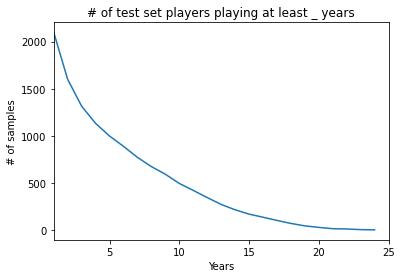

In [131]:
plt.plot([0] + [ens_res[i][0][1] + ens_res[i][1][1] for i in range(24)])
plt.title('# of test set players playing at least _ years')
plt.xlabel('Years')
plt.ylabel('# of samples')
plt.xlim(1, 25)

(23.0, 0.0)

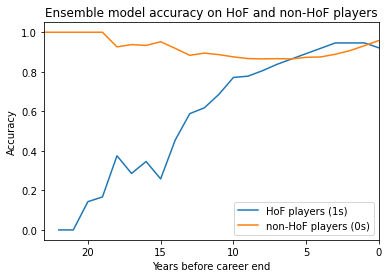

In [84]:
plt.plot(ens_1s_acc)
plt.plot(ens_0s_acc)
plt.xlabel("Years before career end")
plt.ylabel('Accuracy')
plt.title('Ensemble model accuracy on HoF and non-HoF players')
plt.legend(['HoF players (1s)', 'non-HoF players (0s)'])
plt.xlim(23, 0)

(23.0, 0.0)

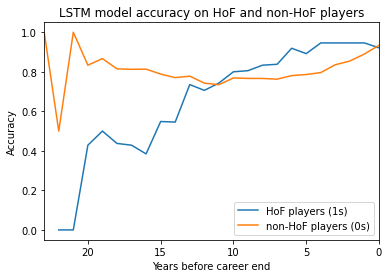

In [98]:
plt.plot(lstm_1s_acc)
plt.plot(lstm_0s_acc)
plt.xlabel("Years before career end")
plt.ylabel('Accuracy')
plt.title('LSTM model accuracy on HoF and non-HoF players')
plt.legend(['HoF players (1s)', 'non-HoF players (0s)'])
plt.xlim(23, 0)

(23.0, 0.0)

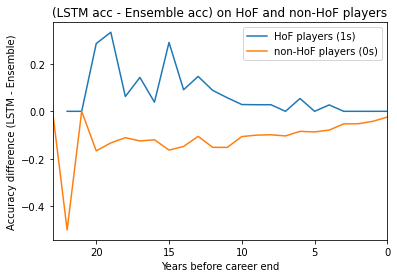

In [102]:
plt.plot(np.array(lstm_1s_acc) - np.array(ens_1s_acc))
plt.plot(np.array(lstm_0s_acc) - np.array(ens_0s_acc))
plt.xlabel("Years before career end")
plt.ylabel('Accuracy difference (LSTM - Ensemble)')
plt.title('(LSTM acc - Ensemble acc) on HoF and non-HoF players')
plt.legend(['HoF players (1s)', 'non-HoF players (0s)'])
plt.xlim(23, 0)

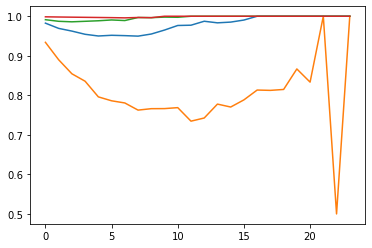

In [125]:
plt.plot(nn_0s_acc)
plt.plot(lstm_0s_acc)
plt.plot(rf_0s_acc)
plt.plot(rf_ts_0s_acc)

## Feature importance using RF classifier

In [153]:
from sklearn.ensemble import RandomForestClassifier

In [154]:
X_train_agg = np.load('../data_ready/agg/X_train.npy')
y_train_agg = np.load('../data_ready/y_train.npy')

In [155]:
X_test_agg = np.load('../data_ready/agg/X_test.npy')

In [ ]:
rf = RandomForestClassifier(class_weight={0:0.05, 1:1.0})
rf.fit(X_train_agg, y_train_agg)

In [172]:
sorted(list(zip(agg_df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'player_id', 'hof']).columns, rf.feature_importances_)), key = lambda x: x[1])

[('hbp', 0.04863456814804448),
 ('sb', 0.04926617129793372),
 ('years_played', 0.05175234012447332),
 ('sh', 0.05227950645904248),
 ('bb', 0.05500461922536896),
 ('triple', 0.06101848283711172),
 ('g', 0.062065256994139784),
 ('ab', 0.06442823674788294),
 ('so', 0.07169406578355435),
 ('rbi', 0.08188617334489112),
 ('hr', 0.08949049471633498),
 ('double', 0.09202374377842927),
 ('h', 0.09243380260127836),
 ('r', 0.12802253794151464)]